In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Introduction

Pytorch has a great ecosystem to load custom datasets for training machine learning models. We use the standard data structure supported by PyTorch ImageLoader. We have Train/Test root folders containing classes with images inside them.

Furthermore, we be use [Albumentations](https://github.com/albumentations-team/albumentations) library for image augmentation. We apply the following augmentations to the training dataset:  
1. SmallestMaxSize - Ensure tha image is first set such that maximum size is 350
2. ShiftScaleRotate
3. RandomCrop
4. RGBShift
5. RandomBrightnessContrast
6. MultiplicativeNoise
7. Normalize
8. HueSaturationValue
9. RandomBrightnessContrast
10. ToTensorV2()

A combination of these transformations is randomly applied to the image before using for training use.

## 2. Import libraries

In [2]:
!pip list | grep opencv

opencv-contrib-python         4.1.2.30
opencv-python                 4.1.2.30


In [3]:
!pip uninstall opencv-python-headless

In [4]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.5 MB/s 


In [5]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 117 kB 4.2 MB/s 
     |████████████████████████████████| 948 kB 15.6 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=881c8e2e855cb23749419fb2a806b8b7a9bd480818fb896d099f73dc2a769b85
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

### 3. Define Params

In [7]:
####################################################
#                Define parameters
####################################################

params = {
#    "model": "resnet50",
    #"device": "cuda",
#    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "n_epochs": 10,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 3
}



### 4. Define Transform

Next, we define our augmentations using Albumentations. We define different augmentations for train and test. We apply transformations related to crop/rotation, colour/saturation, and brightness on training data. We also normalise both train and test data with image net mean and std deviation. Finally, we convert the data to PyTorch tensor using ToTensor().

In [8]:
#######################################################
#               Define Transforms
#######################################################

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=params["image_size"], width=params["image_size"]),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=params["image_size"], width=params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

### 5. Create Train, Valid, and Test sets

Next, we create the Train, Valid, and Test sets. Here we create separate lists of image paths for Train, Valid, and Test sets. These will be used in our Dataset class which will be defined for a custom dataset.


In [9]:
train_data_path = 'drive/MyDrive/images/train'
test_data_path = 'drive/MyDrive/images/test'

In [10]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'drive/MyDrive/images/train' 
test_data_path = 'drive/MyDrive/images/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


#split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 


test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  drive/MyDrive/images/train/pharyngitis/egre34fvdfv.JPG
class example:  pharyngitis

Train size: 131
Valid size: 33
Test size: 136


### 6. Create index_to_class and class_to_index dictionaries
We can’t use the class names directly for models. We create mappings of classes to index and index to classes.

In [11]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}


In [12]:
idx_to_class

{0: 'pharyngitis', 1: 'healthy', 2: 'covid'}

In [13]:
print('Length of train: ', len(train_image_paths))
print('Length of test: ', len(test_image_paths))

Length of train:  131
Length of test:  136


### 7. Create Dataset Class

This is the core of our custom dataset. The structure of the dataset class is something like this:

We create the COVID dataset by inheriting the Dataset class:

> from torch.utils.data import Dataset

and define the `__init__`, `__len__` and `__getitem__` functions as needed by the Dataset class.

Dataset class returns 1 datapoint at a time. PyTorch's Dataloader handles batch operations.


In [14]:
#######################################################
#               Define Dataset Class
#######################################################

class COVIDDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [15]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = COVIDDataset(train_image_paths,train_transforms)
valid_dataset = COVIDDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = COVIDDataset(test_image_paths,test_transforms)



In [23]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 50th image in train dataset:  2


Let’s visualize some images after augmentation through the train_dataset.

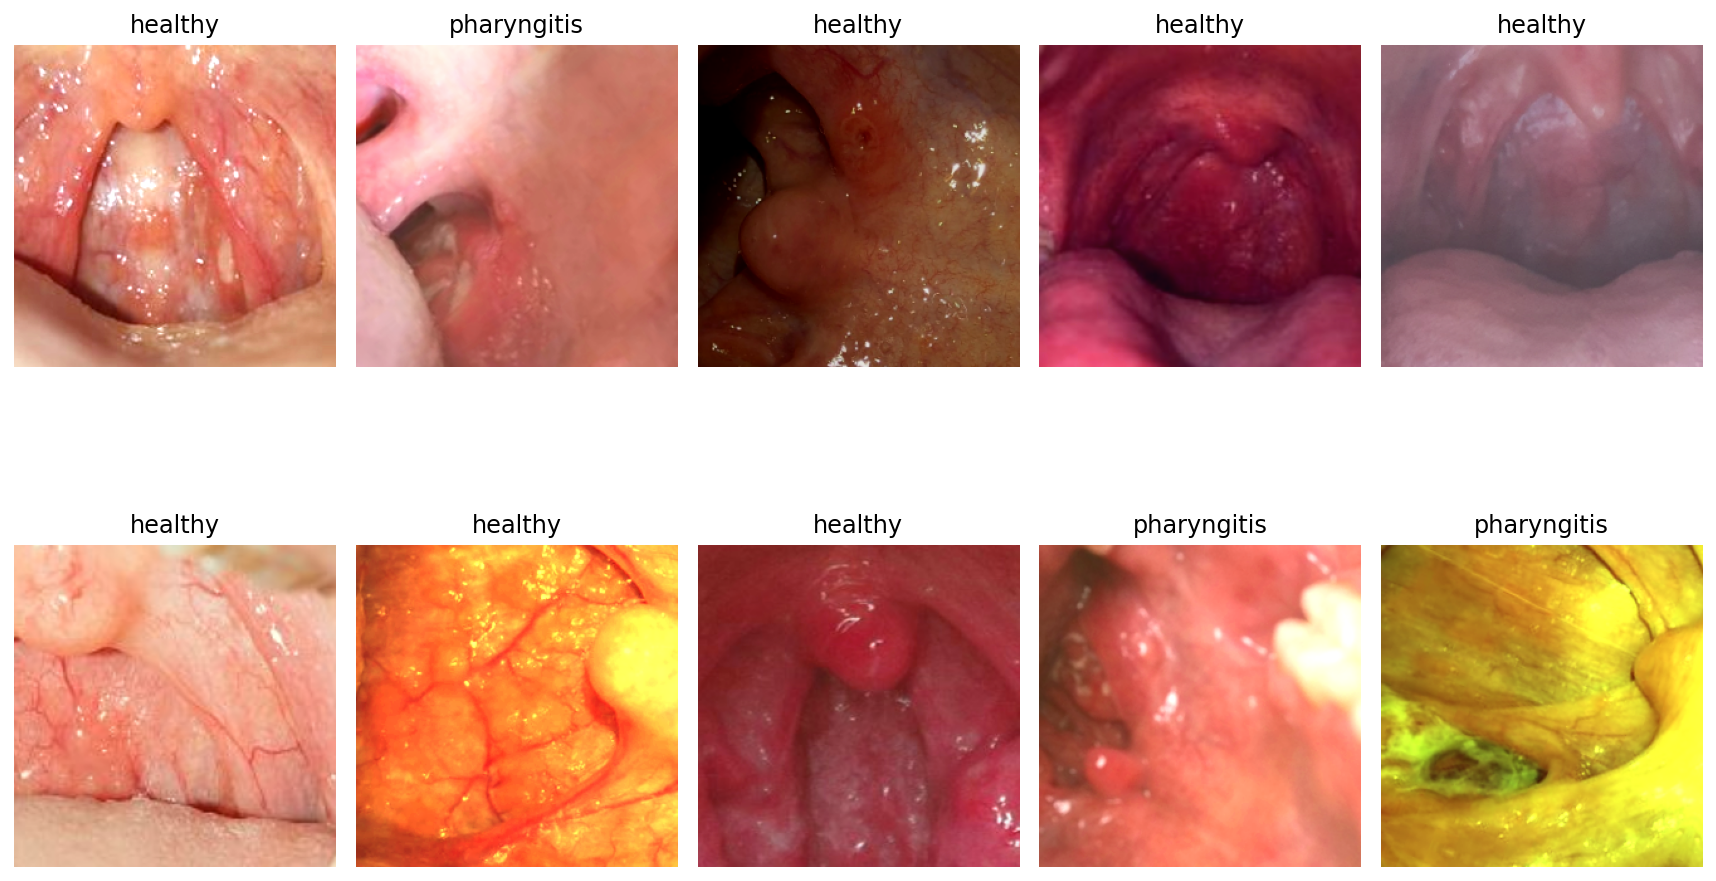

In [25]:
#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

### 8. Creating the DataLoader
The final step. DataLoader class is used to load data in batches for the model. This helps us processing data in mini-batches that can fit within our GPU’s RAM. First, we import the DataLoader:
> from torch.utils.data import DataLoader

Initiating the dataloader by sending in an object of the dataset and the batch size.

In [26]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False
)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Once we have the dataloader instance — train_loader, we can use an iterator to access the data like this:

In [27]:
next(iter(train_loader))[1].shape

torch.Size([64])

This is what we use to batch out the data in our training loop. Every time we run the iterator, the dataloader selects the next 64 indexes and runs it through the __getitem__ in dataset class one by one and then returns it to the training loop.

Now the data is ready to be used in a classification model!

# IMPLEMENTING SPADE (SPatially Adaptive DEnormalization)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SPADE(nn.Module):
    '''
    SPADE Class
    Values:
        channels: the number of channels in the input, a scalar
        cond_channels: the number of channels in conditional input (one-hot semantic labels), a scalar
    '''

    def __init__(self, channels, cond_channels):
        super().__init__()

        self.batchnorm = nn.BatchNorm2d(channels)
        self.spade = nn.Sequential(
            nn.Conv2d(cond_channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, 2 * channels, kernel_size=3, padding=1),
        )

    def forward(self, x, seg):
        # Apply normalization
        x = self.batchnorm(x)

        # Compute denormalization
        seg = F.interpolate(seg, size=x.shape[-2:], mode='nearest')
        gamma, beta = torch.chunk(self.spade(seg), 2, dim=1)

        # Apply denormalization
        x = x * (1 + gamma) + beta
        return x

# Residual Blocks
Implement residual blocks with SPADE normalization. 

In [2]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class
    Values:
        in_channels: the number of input channels, a scalar
        out_channels: the number of output channels, a scalar
        cond_channels: the number of channels in conditional input in spade layer, a scalar
    '''

    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()

        hid_channels = min(in_channels, out_channels)

        self.proj = in_channels != out_channels
        if self.proj:
            self.norm0 = SPADE(in_channels, cond_channels)
            self.conv0 = nn.utils.spectral_norm(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            )

        self.activation = nn.LeakyReLU(0.2)
        self.norm1 = SPADE(in_channels, cond_channels)
        self.norm2 = SPADE(hid_channels, cond_channels)
        self.conv1 = nn.utils.spectral_norm(
            nn.Conv2d(in_channels, hid_channels, kernel_size=3, padding=1)
        )
        self.conv2 = nn.utils.spectral_norm(
            nn.Conv2d(hid_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, seg):
        dx = self.norm1(x, seg)
        dx = self.activation(dx)
        dx = self.conv1(dx)
        dx = self.norm2(dx, seg)
        dx = self.activation(dx)
        dx = self.conv2(dx)

        # Learn skip connection if in_channels != out_channels
        if self.proj:
            x = self.norm0(x, seg)
            x = self.conv0(x)

        return x + dx

# Encoder
GauGAN's encoder encodes the original image into a mean and standard deviation from which to sample noise, which is given to the generator. 

In [3]:
class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
        spatial_size: tuple specifying (height, width) of full size image, a tuple
        z_dim: number of dimensions of latent noise vector (z), a scalar
        n_downsample: number of downsampling blocks in the encoder, a scalar
        base_channels: number of channels in the last hidden layer, a scalar
    '''

    max_channels = 512

    def __init__(self, spatial_size, z_dim=256, n_downsample=6, base_channels=64):
        super().__init__()

        layers = []
        channels = base_channels
        for i in range(n_downsample):
            in_channels = 3 if i == 0 else channels
            out_channels = 2 * z_dim if i < n_downsample else max(self.max_channels, channels * 2)
            layers += [
                nn.utils.spectral_norm(
                    nn.Conv2d(in_channels, out_channels, stride=2, kernel_size=3, padding=1)
                ),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            ]
            channels = out_channels

        h, w = spatial_size[0] // 2 ** n_downsample, spatial_size[1] // 2 ** n_downsample
        layers += [
            nn.Flatten(1),
            nn.Linear(channels * h * w, 2 * z_dim),
        ]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.chunk(self.layers(x), 2, dim=1)

# Generator
The GauGAN generator injects information from the semantic label map at each batch normalization layer, the generator takes random noise as input. This noise is reshaped and upsampled to the target image size.

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        n_classes: the number of object classes in the dataset, a scalar
        bottom_width: the downsampled spatial size of the image, a scalar
        z_dim: the number of dimensions the z noise vector has, a scalar
        base_channels: the number of channels in last hidden layer, a scalar
        n_upsample: the number of upsampling operations to apply, a scalar
    '''

    max_channels = 1024

    def __init__(self, n_classes, spatial_size, z_dim=256, base_channels=64, n_upsample=6):
        super().__init__()

        h, w = spatial_size[0] // 2 ** n_upsample, spatial_size[1] // 2 ** n_upsample
        self.proj_z = nn.Linear(z_dim, self.max_channels * h * w)
        self.reshape = lambda x: torch.reshape(x, (-1, self.max_channels, h, w))

        self.upsample = nn.Upsample(scale_factor=2)
        self.res_blocks = nn.ModuleList()
        for i in reversed(range(n_upsample)):
            in_channels = min(self.max_channels, base_channels * 2 ** (i+1))
            out_channels = min(self.max_channels, base_channels * 2 ** i)
            self.res_blocks.append(ResidualBlock(in_channels, out_channels, n_classes))

        self.proj_o = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, seg):
        h = self.proj_z(z)
        h = self.reshape(h)
        for res_block in self.res_blocks:
            h = res_block(h, seg)
            h = self.upsample(h)
        h = self.proj_o(h)
        return h

# Discriminator
The architecture of the discriminator uses a multi-scale design with the InstanceNorm. Spectral normalization is applied to all convolutional layers. GauGAN's discriminator also takes as input the image concatenated with the semantic label map.

In [5]:
class PatchGANDiscriminator(nn.Module):
    '''
    PatchGANDiscriminator Class
    Implements the discriminator class for a subdiscriminator, 
    which can be used for all the different scales, just with different argument values.
    Values:
        in_channels: the number of channels in input, a scalar
        base_channels: the number of channels in first convolutional layer, a scalar
        n_layers: the number of convolutional layers, a scalar
    '''

    def __init__(self, in_channels, base_channels=64, n_layers=3):
        super().__init__()

        # Use nn.ModuleList so we can output intermediate values for loss.
        self.layers = nn.ModuleList()

        # Initial convolutional layer
        self.layers.append(
            nn.Sequential(
                nn.utils.spectral_norm(
                    nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=2)
                ),
                nn.LeakyReLU(0.2, inplace=True),
            )
        )

        # Downsampling convolutional layers
        channels = base_channels
        for _ in range(1, n_layers):
            prev_channels = channels
            channels = min(2 * channels, 512)
            self.layers.append(
                nn.Sequential(
                    nn.utils.spectral_norm(
                        nn.Conv2d(prev_channels, channels, kernel_size=4, stride=2, padding=2)
                    ),
                    nn.InstanceNorm2d(channels, affine=False),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )

        # Output convolutional layer
        prev_channels = channels
        channels = min(2 * channels, 512)
        self.layers.append(
            nn.Sequential(
                nn.utils.spectral_norm(
                    nn.Conv2d(prev_channels, channels, kernel_size=4, stride=1, padding=2))
                ,
                nn.InstanceNorm2d(channels, affine=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, 1, kernel_size=4, stride=1, padding=2)
                ),
            )
        )

    def forward(self, x):
        outputs = [] # for feature matching loss
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)

        return outputs

# Multiscale Discriminator

In [6]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        in_channels: number of input channels to each discriminator, a scalar
        base_channels: number of channels in last hidden layer, a scalar
        n_layers: number of downsampling layers in each discriminator, a scalar
        n_discriminators: number of discriminators at different scales, a scalar
    '''

    def __init__(self, in_channels, base_channels=64, n_layers=3, n_discriminators=3):
        super().__init__()

        # Initialize all discriminators
        self.discriminators = nn.ModuleList()
        for _ in range(n_discriminators):
            self.discriminators.append(
                PatchGANDiscriminator(in_channels, base_channels=base_channels, n_layers=n_layers)
            )

        # Downsampling layer to pass inputs between discriminators at different scales
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    def forward(self, x):
        outputs = []

        for i, discriminator in enumerate(self.discriminators):
            # Downsample input for subsequent discriminators
            if i != 0:
                x = self.downsample(x)

            outputs.append(discriminator(x))

        # Return list of multiscale discriminator outputs
        return outputs

    @property
    def n_discriminators(self):
        return len(self.discriminators)

# Creating the GauGAN

Encoder outputs mean and log-variance values to sample random noise from, this implementation will use the 'reparameterization' to allow gradient flow to the encoder. 

In [7]:
class GauGAN(nn.Module):
    '''
    GauGAN Class
    Values:
        n_classes: number of object classes in dataset, a scalar
        spatial_size: tuple containing (height, width) of full-size image, a tuple
        base_channels: number of channels in last generator & first discriminator layers, a scalar
        z_dim: number of dimensions in noise vector (z), a scalar
        n_upsample: number of downsampling (encoder) and upsampling (generator) operations, a scalar
        n_disc_layer:: number of discriminator layers, a scalar
        n_disc: number of discriminators (at different scales), a scalar
    '''

    def __init__(
        self,
        n_classes,
        spatial_size,
        base_channels=64,
        z_dim=256,
        n_upsample=6,
        n_disc_layers=3,
        n_disc=3,
    ):
        super().__init__()

        self.encoder = Encoder(
            spatial_size, z_dim=z_dim, n_downsample=n_upsample, base_channels=base_channels,
        )
        self.generator = Generator(
            n_classes, spatial_size, z_dim=z_dim, base_channels=base_channels, n_upsample=n_upsample,
        )
        self.discriminator = Discriminator(
            n_classes + 3, base_channels=base_channels, n_layers=n_disc_layers, n_discriminators=n_disc,
        )

    def forward(self, x, seg):
        ''' Performs a full forward pass for training. '''
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        x_fake = self.generate(z, seg)
        pred = self.discriminate(x_fake, seg)
        return x_fake, pred

    def encode(self, x):
        return self.encoder(x)

    def generate(self, z, seg):
        ''' Generates fake image from noise vector and segmentation. '''
        return self.generator(z, seg)

    def discriminate(self, x, seg):
        ''' Predicts whether input image is real. '''
        return self.discriminator(torch.cat((x, seg), dim=1))

    @staticmethod
    def sample_z(mu, logvar):
        ''' Samples noise vector with reparameterization trick. '''
        eps = torch.randn(mu.size(), device=mu.device).to(mu.dtype)
        return (logvar / 2).exp() * eps + mu

    @property
    def n_disc(self):
        return self.discriminator.n_discriminators

# Loss Functions
GauGAN reuses the composite loss functions that Pix2PixHD does, except it replaces the LSGAN loss with Hinge loss. It imposes a soft (0.05 weight) Kullbach-Leibler Divergence (KLD) loss term on the Gaussian statistics generated by the encoder.

In [8]:
import torchvision.models as models

class VGG19(nn.Module):
    '''
    VGG19 Class
    Wrapper for pretrained torchvision.models.vgg19 to output intermediate feature maps
    '''

    def __init__(self):
        super().__init__()
        vgg_features = models.vgg19(pretrained=True).features

        self.f1 = nn.Sequential(*[vgg_features[x] for x in range(2)])
        self.f2 = nn.Sequential(*[vgg_features[x] for x in range(2, 7)])
        self.f3 = nn.Sequential(*[vgg_features[x] for x in range(7, 12)])
        self.f4 = nn.Sequential(*[vgg_features[x] for x in range(12, 21)])
        self.f5 = nn.Sequential(*[vgg_features[x] for x in range(21, 30)])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h1 = self.f1(x)
        h2 = self.f2(h1)
        h3 = self.f3(h2)
        h4 = self.f4(h3)
        h5 = self.f5(h4)
        return [h1, h2, h3, h4, h5]

class Loss(nn.Module):
    '''
    Loss Class
    Implements composite loss for GauGAN
    Values:
        lambda1: weight for feature matching loss, a float
        lambda2: weight for vgg perceptual loss, a float
        lambda3: weight for KLD loss, a float
        device: 'cuda' or 'cpu' for hardware to use
        norm_weight_to_one: whether to normalize weights to (0, 1], a bool
    '''

    def __init__(self, lambda1=10., lambda2=10., lambda3=0.05, device='cuda', norm_weight_to_one=True):
        super().__init__()

        self.vgg = VGG19().to(device)
        self.vgg_weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]

        lambda0 = 1.0
        # Keep ratio of composite loss, but scale down max to 1.0
        scale = max(lambda0, lambda1, lambda2, lambda3) if norm_weight_to_one else 1.0

        self.lambda0 = lambda0 / scale
        self.lambda1 = lambda1 / scale
        self.lambda2 = lambda2 / scale
        self.lambda3 = lambda3 / scale

    def kld_loss(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())

    def g_adv_loss(self, discriminator_preds):
        adv_loss = 0.0
        for preds in discriminator_preds:
            pred = preds[-1]
            adv_loss += -pred.mean()
        return adv_loss

    def d_adv_loss(self, discriminator_preds, is_real):
        adv_loss = 0.0
        for preds in discriminator_preds:
            pred = preds[-1]
            target = -1 + pred if is_real else -1 - pred
            mask = target < 0
            adv_loss += (mask * target).mean()
        return adv_loss

    def fm_loss(self, real_preds, fake_preds):
        fm_loss = 0.0
        for real_features, fake_features in zip(real_preds, fake_preds):
            for real_feature, fake_feature in zip(real_features, fake_features):
                fm_loss += F.l1_loss(real_feature.detach(), fake_feature)
        return fm_loss

    def vgg_loss(self, x_real, x_fake):
        vgg_real = self.vgg(x_real)
        vgg_fake = self.vgg(x_fake)

        vgg_loss = 0.0
        for real, fake, weight in zip(vgg_real, vgg_fake, self.vgg_weights):
            vgg_loss += weight * F.l1_loss(real.detach(), fake)
        return vgg_loss

    def forward(self, x_real, label_map, gaugan):
        '''
        Function that computes the forward pass and total loss for GauGAN.
        '''
        mu, logvar = gaugan.encode(x_real)
        z = gaugan.sample_z(mu, logvar)
        x_fake = gaugan.generate(z, label_map)

        # Get necessary outputs for loss/backprop for both generator and discriminator
        fake_preds_for_g = gaugan.discriminate(x_fake, label_map)
        fake_preds_for_d = gaugan.discriminate(x_fake.detach(), label_map)
        real_preds_for_d = gaugan.discriminate(x_real.detach(), label_map)

        g_loss = (
            self.lambda0 * self.g_adv_loss(fake_preds_for_g) + \
            self.lambda1 * self.fm_loss(real_preds_for_d, fake_preds_for_g) / gaugan.n_disc + \
            self.lambda2 * self.vgg_loss(x_fake, x_real) + \
            self.lambda3 * self.kld_loss(mu, logvar)
        )
        d_loss = 0.5 * (
            self.d_adv_loss(real_preds_for_d, True) + \
            self.d_adv_loss(fake_preds_for_d, False)
        )

        return g_loss, d_loss, x_fake.detach()

# Training GauGAN

In [9]:
import os

import numpy as np
import torchvision.transforms as transforms
from PIL import Image

class COVIDDataset2(torch.utils.data.Dataset):
    '''
    COVIDDataset2 Class
    Values:
        paths: (a list of) paths to construct dataset from, a list or string
        img_size: tuple containing the (height, width) for resizing, a tuple
        n_classes: the number of object classes, a scalar
    '''

    def __init__(self, paths, img_size=(256, 512), n_classes=3):
        super().__init__()

        self.n_classes = n_classes

        # Collect list of examples
        self.examples = {}
        if type(paths) == str:
            self.load_examples_from_dir(paths)
        elif type(paths) == list:
            for path in paths:
                self.load_examples_from_dir(path)
        else:
            raise ValueError('`paths` should be a single path or list of paths')

        self.examples = list(self.examples.values())
        assert all(len(example) == 2 for example in self.examples)

        # Initialize transforms for the real color image
        self.img_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Initialize transforms for semantic label maps
        self.map_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
        ])

    def load_examples_from_dir(self, abs_path):
        '''
        Given a folder of examples, this function returns a list of paired examples.
        '''
        assert os.path.isdir(abs_path)

        img_suffix = '_leftImg8bit.png'
        label_suffix = '_gtFine_labelIds.png'

        for root, _, files in os.walk(abs_path):
            for f in files:
                if f.endswith(img_suffix):
                    prefix = f[:-len(img_suffix)]
                    attr = 'orig_img'
                elif f.endswith(label_suffix):
                    prefix = f[:-len(label_suffix)]
                    attr = 'label_map'
                else:
                    continue

                if prefix not in self.examples.keys():
                    self.examples[prefix] = {}
                self.examples[prefix][attr] = root + '/' + f

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Load image and maps
        img = Image.open(example['orig_img']).convert('RGB') # color image: (3, h, w)
        label = Image.open(example['label_map'])             # semantic label map: (1, h, w)

        # Apply corresponding transforms
        img = self.img_transforms(img)
        label = self.map_transforms(label).long() * 255

        # Convert labels to one-hot vectors
        label = F.one_hot(label, num_classes=self.n_classes)
        label = label.squeeze(0).permute(2, 0, 1).to(img.dtype)

        return (img, label)

    def __len__(self):
        return len(self.examples)

    @staticmethod
    def collate_fn(batch):
        imgs, labels = [], []
        for (x, l) in batch:
            imgs.append(x)
            labels.append(l)
        return torch.stack(imgs, dim=0), torch.stack(labels, dim=0)

# Initializing for training

In [16]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def lr_lambda(epoch):
    ''' Function for scheduling learning rate '''
    return 1. if epoch < decay_after else 1 - float(epoch - decay_after) / (epochs - decay_after)

def weights_init(m):
    ''' Function for initializing all model weights '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weights_init)

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gaugan_config = {
    'n_classes': 3,
    'spatial_size': (128, 256), # Default (256, 512): halve size for memory
    'base_channels': 32,        # Default 64: halve channels for memory
    'z_dim': 256,
    'n_upsample': 5,            # Default 6: decrease layers for memory
    'n_disc_layers': 2,
    'n_disc': 3,
}
gaugan = GauGAN(**gaugan_config).to(device)
loss = Loss(device=device)

# Initialize dataloader
train_dir = ['drive/MyDrive/images/train']
batch_size2 = 16                 # Default 32: decrease for memory
dataset = COVIDDataset2(
    train_dir, img_size=gaugan_config['spatial_size'], n_classes=gaugan_config['n_classes'],
)
dataloader2 = DataLoader(
    dataset, collate_fn=COVIDDataset2.collate_fn
   # batch_size=batch_size2, shuffle=True,
    #drop_last=False, pin_memory=True,
)
# Initialize optimizers + schedulers
epochs = 200                    # total number of train epochs
decay_after = 100               # number of epochs with constant lr
betas = (0.0, 0.999)

g_params = list(gaugan.generator.parameters()) + list(gaugan.encoder.parameters())
d_params = list(gaugan.discriminator.parameters())

g_optimizer = torch.optim.Adam(g_params, lr=1e-4, betas=betas)
d_optimizer = torch.optim.Adam(d_params, lr=4e-4, betas=betas)
g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lr_lambda)
d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)

In [17]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Parse torch version for autocast
# #################################################
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)
# #################################################

def show_tensor_images(image_tensor):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:1], nrow=1)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def train(dataloader2, gaugan, optimizers, schedulers, device):
    g_optimizer, d_optimizer = optimizers
    g_scheduler, d_scheduler = schedulers

    cur_step = 0
    display_step = 100

    mean_g_loss = 0.0
    mean_d_loss = 0.0

    for epoch in range(epochs):
        # Training epoch
        for (x_real, labels) in tqdm(dataloader2, position=0):
            x_real = x_real.to(device)
            labels = labels.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    g_loss, d_loss, x_fake = loss(x_real, labels, gaugan)
            else:
                g_loss, d_loss, x_fake = loss(x_real, labels, gaugan)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: Generator loss: {:.5f}, Discriminator loss: {:.5f}'
                      .format(cur_step, mean_g_loss, mean_d_loss))
                show_tensor_images(x_fake.to(x_real.dtype))
                show_tensor_images(x_real)
                mean_g_loss = 0.0
                mean_d_loss = 0.0
            cur_step += 1

        g_scheduler.step()
        d_scheduler.step()

train(
    dataloader2, gaugan,
    [g_optimizer, d_optimizer],
    [g_scheduler, d_scheduler],
    device,
)

0it [00:00, ?it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, 